In [1]:
import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
import numpy as np
import matplotlib as mpl
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


from models import NetD, NetG

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
display(f'Device {device} is available.')

'Device cuda is available.'

In [3]:
dc_gen = NetG().to(device)
dc_dis = NetD().to(device)

batch_size = 32
#lr = 0.0002
lr = 0.0002
epochs = 30
loss_fn = nn.BCELoss()
fixed_noise = torch.randn((64, 100, 1,1), device=device)
fixed_labels = torch.randint(0,10, (64,1)).to(device)
# Other normalization factors are located here:  https://github.com/kuangliu/pytorch-cifar/issues/19
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = DataLoader(datasets.CIFAR10(root='./hw4data', train=True, transform=transform, download=True), batch_size=batch_size,shuffle=True)
test_loader =  DataLoader(datasets.CIFAR10(root='./hw4data', train=False, transform=transform, download=True), batch_size=batch_size,shuffle=True)

gen_optimizer = Adam(dc_gen.parameters(), lr=lr, betas=(.5, .999))
dis_optimizer = Adam(dc_dis.parameters(), lr=lr, betas=(.5, .999))
#dis_optimizer = SGD(dc_dis.parameters(), lr=lr) 

Files already downloaded and verified
Files already downloaded and verified


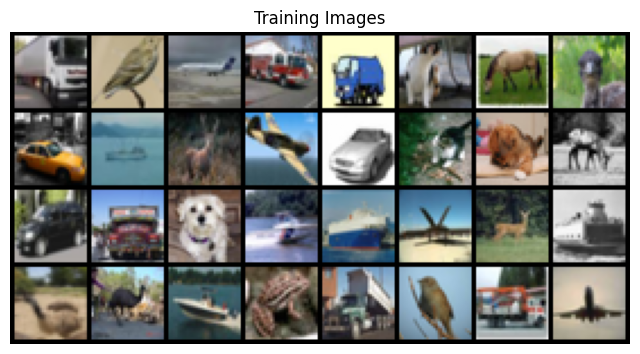

In [4]:
data = next(iter(train_loader))
data[0].shape

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(data[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [5]:

def init_weights(m):
    """Adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html. """
    clazz = m.__class__.__name__
    if clazz.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif clazz.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

dc_gen.apply(init_weights)
dc_dis.apply(init_weights)

display(dc_gen)
display(dc_dis)



NetG(
  (embedding): Embedding(10, 100)
  (sequence): Sequential(
    (0): ConvTranspose2d(200, 640, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(640, 320, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(320, 160, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(160, 80, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(80, 3, kernel_size=(4, 4), stride=(2, 2), pa

NetD(
  (sequence): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [6]:
def train(g, d, gen_optimizer, dis_optimizer, loss_fn, train_loader, epoch):
    derrors, gerrors, gen_imgs= [],[], []
    
    for idx, data in enumerate(train_loader):    
        d.zero_grad()
        imgs = data[0].to(device)
        batch_size = imgs.size(0)
        label = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        
        # Real images with discriminator
        output = d(imgs)
        
        d_real_error = loss_fn(output.squeeze(), label)
        d_real_error.backward()      

        # Fake images with discriminator
        zvector = torch.randn((batch_size, 100, 1, 1), device=device)
        fakes = g(zvector, data[1].to(device))
        output = d(fakes.detach())
        bad_label = torch.full((batch_size,), 0, dtype=torch.float, device=device)
        d_fake_error = loss_fn(output.squeeze(),bad_label)
        d_fake_error.backward()

        total_Derror = d_fake_error + d_real_error
        derrors.append(total_Derror.item())
        dis_optimizer.step()

        # Do the loss of G
        g.zero_grad()
        trick_label = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        #fakes = g(zvector)
        output = d(fakes)
        g_error = loss_fn(output.squeeze(), trick_label)
        gerrors.append(g_error.item())
        #print(g_error)
        g_error.backward()
        gen_optimizer.step()

        if idx == (len(train_loader) -1) and (epoch+1) % 5 == 0:
            with torch.no_grad():
                
                #torch.randint(0,10, (64,1)).to(device).detach().cpu()
                extra_fake = g(fixed_noise, fixed_labels) #data[1].to(device)).detach().cpu()
                gen_imgs.append(vutils.make_grid(extra_fake, padding=2, normalize=True))
                
            

    return derrors, gerrors, gen_imgs

In [7]:
# Training Loop
alld, allg, all_imgs = [],[],[]
for epoch in range(epochs):
    d_real_error, g_error, gen_imgs = train(dc_gen, dc_dis, gen_optimizer, dis_optimizer, loss_fn, train_loader, epoch)
    print(epoch, d_real_error[-1], g_error[-1])
    alld.extend(d_real_error)
    allg.extend(g_error)
    all_imgs.extend(gen_imgs)


0 1.1302248239517212 3.681687116622925
1 0.9551229476928711 4.28435754776001
2 0.4935160279273987 4.162604808807373
3 0.5692422389984131 2.8504858016967773
4 1.0378658771514893 3.988759994506836
5 1.1828062534332275 7.584315299987793
6 0.6083541512489319 4.068602561950684
7 0.25612109899520874 3.8662266731262207
8 1.1972854137420654 10.267829895019531
9 1.2901782989501953 2.9227042198181152
10 0.37837284803390503 6.181748390197754
11 0.9180258512496948 5.779009819030762
12 0.30591171979904175 3.545289993286133
13 0.5911533832550049 3.4338645935058594
14 0.6056280136108398 3.087780714035034
15 1.3710966110229492 2.004805088043213
16 0.13825315237045288 4.697605609893799
17 1.0037368535995483 2.37905216217041
18 0.1607038676738739 7.014610290527344
19 0.1196623146533966 4.200629711151123
20 0.8913291692733765 5.129697799682617
21 0.040278539061546326 5.476409912109375
22 0.6272495985031128 4.219038009643555
23 0.10657712072134018 4.813175201416016
24 0.9723728895187378 5.155491352081299


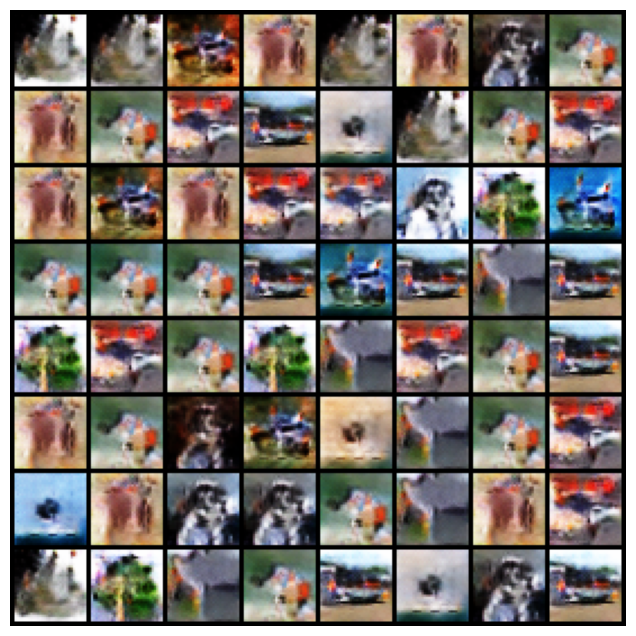

In [8]:
mpl.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(8,8))
plt.axis("off")
image = [[plt.imshow(np.transpose(i.cpu(), (1,2,0)), animated=True)] for i in all_imgs]
ani = animation.ArtistAnimation(fig, image, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [9]:
len(allg)

46890

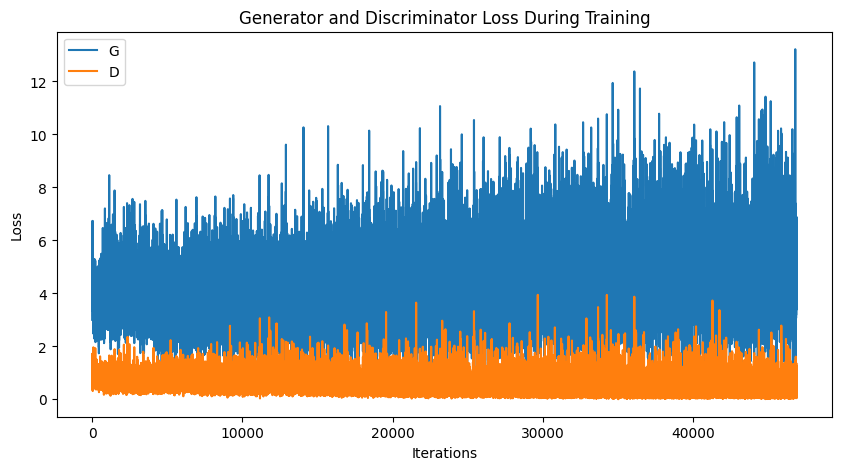

In [10]:
# alliters = list(range(alld))

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(allg,label="G")
plt.plot(alld,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()